# Лабораторная №5

In [ ]:
import numpy as np


args = {
    'l': np.pi,
    'Psi': lambda x: np.sin(0),
    'Function': lambda x, t: np.cos(x)*(np.sin(t)+np.cos(t)),
    'Phi0': lambda t: np.sin(t),
    'PhiL': lambda t: -np.sin(t),
    'AnaliticalSolution': lambda x, t: np.sin(t)*np.cos(x),
    'type': '1-1',
    'algorithm': 'Implicit'
}

In [ ]:
class ParabolicSolver:
    def __init__(self, args):
        functionName = ''
        for name, value in args.items():
            setattr(self, name, value)
        for word in args['algorithm'].split():
            first = word[0].upper()
            word = word[1:].lower()
            functionName += first + word
        try:
            self.SolveFunction = getattr(self, functionName)
        except:
            raise Exception("Данный тип не поддерживается, выберите Implicit, Explicit или Crank Nicholson")

    def Solve(self, N, K, T):
        self.h = self.l / N
        self.tau = T / K
        self.sigma = self.tau / (self.h ** 2)
        return self.SolveFunction(N, K, T)

    def AnaliticalSolutionMatrix(self, N, K, T):
        self.h = self.l / N;
        self.tau = T / K;
        self.u = np.zeros((K, N))
        for k in range(K):
            for j in range(N):
                self.u[k][j] = self.AnaliticalSolution(j * self.h, k * self.tau)
        return self.u

    def RunThroughMethod(self):
        size = len(self.a)
        p = np.zeros(size)
        q = np.zeros(size)
        p[0] = (-self.c[0] / self.b[0])
        q[0] = (self.d[0] / self.b[0])

        for i in range(1, size):
            p[i] = -self.c[i] / (self.b[i] + self.a[i] * p[i - 1])
            q[i] = (self.d[i] - self.a[i] * q[i - 1]) / (self.b[i] + self.a[i] * p[i - 1])

        x = np.zeros(size)
        x[-1] = q[-1]

        for i in range(size - 2, -1, -1):
            x[i] = p[i] * x[i + 1] + q[i]

        return x

    def Implicit(self, N, K, T):
        self.a = np.zeros(N)
        self.b = np.zeros(N)
        self.c = np.zeros(N)
        self.d = np.zeros(N)
        self.u = np.zeros((K, N))

        for i in range(1, N - 1):
            self.u[0][i] = self.Psi(i * self.h)
        self.u[0][-1] = 0

        for k in range(1, K):
            for j in range(1, N - 1):
                self.a[j] = self.sigma
                self.b[j] = -(1 + 2 * self.sigma)
                self.c[j] = self.sigma
                self.d[j] = -self.u[k - 1][j] - self.tau * self.Function(j * self.h, k * self.tau)

            self.a[0] = 0
            self.b[0] = -(1 + 2 * self.sigma)
            self.c[0] = self.sigma
            self.a[-1] = self.sigma
            self.b[-1] = -(1 + 2 * self.sigma)
            self.c[-1] = 0

            if self.type == '1-1':
                self.d[0] = -(self.u[k - 1][0] + self.sigma * self.Phi0(k * self.tau))
                self.d[-1] = -(self.u[k - 1][-1] + self.sigma * self.PhiL(k * self.tau))

            elif self.type == '2-2':
                self.d[0] = -(self.u[k - 1][0] + self.sigma * self.Phi0(k * self.tau)) - self.tau * self.Function(0, k * self.tau)
                self.d[-1] = -(self.u[k - 1][-1] + self.sigma * self.PhiL(k * self.tau)) - self.tau * self.Function((N - 1) * self.h, k * self.tau)

            elif self.type == '2-3':
                self.d[0] = -((1 - self.sigma) * self.u[k - 1][1] + self.sigma / 2 * self.u[k - 1][0]) - self.tau * Function(0, k * self.tau) - self.sigma * self.Phi0(k * self.tau)
                self.d[-1] = self.PhiL(k * self.tau) + self.Function((N - 1) * self.h, k * self.tau) * self.h / (2 * self.tau) * self.u[k - 1][-1]

            self.u[k] = self.RunThroughMethod()

        return self.u

    def Explicit(self, N, K, T):
        self.u = np.zeros((K, N))
        for j in range(1, N - 1):
            self.u[0][j] = self.Psi(j * self.h)

        for k in range(1, K):
            self.u[k][0] = self.Phi0(k * self.tau)
            for j in range(1, N - 1):
                self.u[k][j] = self.sigma * self.u[k - 1][j + 1] + (1 - 2 * self.sigma) * self.u[k - 1][j] + self.sigma * self.u[k - 1][j - 1] + self.tau * self.Function(j * self.h, k * self.tau)

            if self.type == '1-1':
                self.u[k][-1] = self.u[k][-2] + self.PhiL(k * self.tau) * self.h
            elif self.type == '2-2':
                self.u[k][-1] = self.PhiL(k * self.tau)
            elif self.type == '2-3':
                self.u[k][-1] = (self.PhiL(k * self.tau) + self.u[k][-2] / self.h + 2 * self.tau * self.u[k - 1][-1] / self.h) / (1 / self.h + 2 * self.tau / self.h)

        return self.u

    def CrankNicholson(self, N, K, T):
        theta = 0.5
        self.a = np.zeros(N)
        self.b = np.zeros(N)
        self.c = np.zeros(N)
        self.d = np.zeros(N)
        uImplisit = np.zeros(N)
        self.u = np.zeros((K, N))
        for j in range(1, N - 1):
            self.u[0][j] = self.Psi(j * self.h)

        for k in range(1, K):
            for j in range(1, N - 1):
                self.a[j] = self.sigma
                self.b[j] = -(1 + 2 * self.sigma)
                self.c[j] = self.sigma
                self.d[j] = -self.u[k - 1][j] - self.tau * self.Function(j * self.h, k * self.tau)

            self.a[0] = 0
            self.b[0] = -(1 + 2 * self.sigma)
            self.c[0] = self.sigma
            self.a[-1] = self.sigma
            self.b[-1] = -(1 + 2 * self.sigma)
            self.c[-1] = 0

            if self.type == '1-1':
                self.d[0] = -(self.u[k - 1][0] + self.sigma * self.Phi0(k * self.tau))
                self.d[-1] = -(self.u[k - 1][-1] + self.sigma * self.PhiL(k * self.tau))

            elif self.type == '2-2':
                self.d[0] = -(self.u[k - 1][0] + self.sigma * self.Phi0(k * self.tau)) - self.tau * self.Function(0, k * self.tau)
                self.d[-1] = -(self.u[k - 1][-1] + self.sigma * self.PhiL(k * self.tau)) - self.tau * self.Function((N - 1) * self.h, k * self.tau)

            elif self.type == '2-3':
                self.d[0] = -((1 - self.sigma) * self.u[k - 1][1] + self.sigma / 2 * self.u[k - 1][0]) - self.tau * Function(0, k * self.tau) - self.sigma * self.Phi0(k * self.tau)
                self.d[-1] = self.PhiL(k * self.tau) + self.Function((N - 1) * self.h, k * self.tau) * self.h / (2 * self.tau) * self.u[k - 1][-1]

            uImplisit = self.RunThroughMethod()

            uExplisit = np.zeros(N)
            for j in range(1, N - 1):
                uImplisit[j] = self.sigma * self.u[k - 1][j + 1] + (1 - 2 * self.sigma) * self.u[k - 1][j] + self.sigma * self.u[k - 1][j - 1] + self.tau * self.Function(j * self.h, k * self.tau)

            if self.type == '1-1':
                uImplisit[-1] = self.u[k][-2] + self.PhiL(k * self.tau) * self.h
            elif self.type == '2-2':
                uImplisit[-1] = self.PhiL(k * self.tau)
            elif self.type == '2-3':
                uImplisit[-1] = (self.PhiL(k * self.tau) + self.u[k][-2] / self.h + 2 * self.tau * self.u[k - 1][-1] / self.h) / (1 / self.h + 2 * self.tau / self.h)

            for j in range(N):
                self.u[k][j] = theta * uImplisit[j] + (1 - theta) * uExplisit[j]

        return self.u

In [ ]:
algorithms = ('Implicit', 'Explicit', 'Crank Nicholson')
T, K, N = 10, 500, 5

answers = dict()
solver = ParabolicSolver(args)
analytic = solver.AnaliticalSolutionMatrix(N, K, T)
answers['Analytic'] = analytic
for algorithm in algorithms:
    args['algorithm'] = algorithm
    solver = ParabolicSolver(args)
    numeric = solver.Solve(N, K, T)
    answers[algorithm] = numeric

<Figure size 800x500 with 0 Axes>

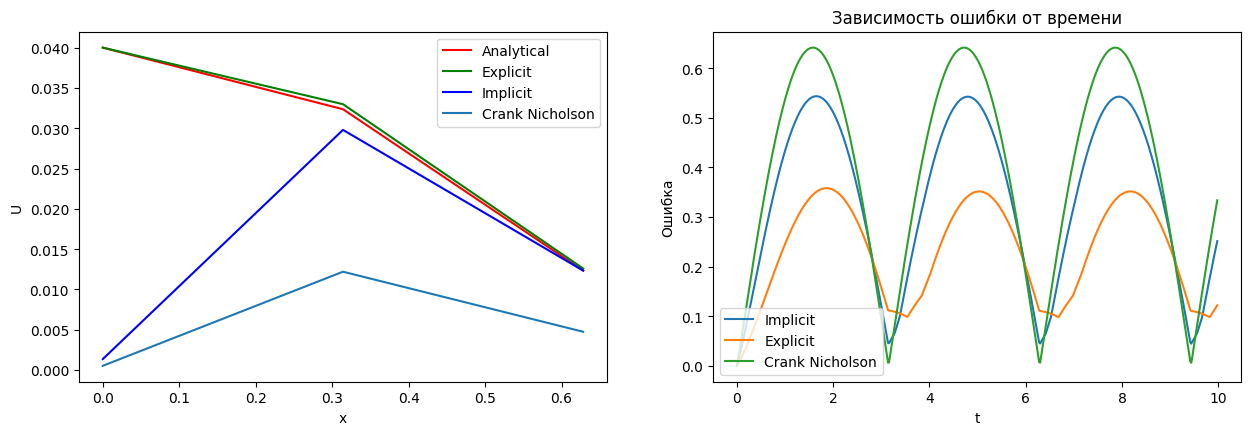

In [ ]:
import matplotlib.pyplot as plt


def GetError(numeric, analytic):
    err = []
    error = [[abs(i - j) for i, j in zip(x, y)] for x, y in zip(numeric, analytic)]
    for i in range(len(error)):
        tmp = 0
        for j in error[i]:
            tmp += j
        err.append(tmp / len(error[i]))
    return err

def Draw2DCharts(answers, N, K, T, time=2):
    fig = plt.figure(figsize=(8, 5))
    x = np.arange(0, np.pi / 2, np.pi / 2 / N)
    t = np.arange(0, T, T / K)
    z1 = np.array(answers['Analytic'])
    z2 = np.array(answers['Explicit'])
    z3 = np.array(answers['Implicit'])
    z4 = np.array(answers['Crank Nicholson'])

    figure = plt.figure(figsize=(15, 10))
    axes = figure.add_subplot(221)
    plt.plot(x[0:-2], z1[time][0:-2], color='r', label='Analytical')
    plt.plot(x[0:-2], z2[time][0:-2], color='g', label='Explicit')
    plt.plot(x[0:-2], z3[time][0:-2], color='b', label='Implicit')
    plt.plot(x[0:-2], z4[time][0:-2], label='Crank Nicholson')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('x')
    # plt.show()
    axes = figure.add_subplot(222)
    plt.title('Зависимость ошибки от времени')
    for method in algorithms:
        plt.plot(t, GetError(answers[method], answers['Analytic']), label=method)
    plt.legend(loc='best')
    plt.ylabel('Ошибка')
    plt.xlabel('t')
    plt.show()
    # plt.show()

Draw2DCharts(answers, N, K, T)